<a href="https://colab.research.google.com/github/Gaussiandra/bdimo21/blob/main/new15_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# reg
# 0 как таргеты
# балансировка
# больше агригаций

In [2]:
!free -m

              total        used        free      shared  buff/cache   available
Mem:          26124         625       24514           0         984       25159
Swap:             0           0           0


In [3]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
!pip install catboost

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import os
import sys
import numpy as np
import pandas as pd
import sklearn
import numpy as np
import lightgbm
from sklearn.model_selection import train_test_split
import joblib
import scipy as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression, Ridge, RidgeClassifier
from sklearn.pipeline import make_pipeline
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import seaborn as sns
from tqdm.auto import tqdm
sns.set()

In [7]:
sys.path.append('/content/drive/MyDrive/ML/bdimo21/')

In [8]:
import submission
import importlib
importlib.reload(submission)

<module 'submission' from '/content/drive/MyDrive/ML/bdimo21/submission.py'>

In [9]:
import catboost

In [10]:
global_path = '/content/drive/MyDrive/ML/bdimo21/'

In [11]:
rheed_long = pd.read_csv(global_path+"ONTI_Dataset_parsed.csv", parse_dates=[6])
ma_coolness = rheed_long['Coolness_RHEED'].rolling(50).mean()
rheed_long['target'] = abs(ma_coolness-ma_coolness.shift(-435))

In [12]:
df = submission.preprocess(rheed_long, is_train=True)

In [13]:
df

,Coolness_RHEED,R FWHM_RHEED,X FWHM_RHEED,Y FWHM_RHEED,Filtered Rate,Raw Rate,Source Power,Crystal Position,Fundamental Freq,Speed_RHEED,Length_RHEED,Speed,Coolness_RHEED_mean_50,Coolness_RHEED_std_50,Coolness_RHEED_median_50,Coolness_RHEED_min_50,Coolness_RHEED_max_50,R FWHM_RHEED_mean_50,R FWHM_RHEED_std_50,R FWHM_RHEED_median_50,R FWHM_RHEED_min_50,R FWHM_RHEED_max_50,X FWHM_RHEED_mean_50,X FWHM_RHEED_std_50,X FWHM_RHEED_median_50,X FWHM_RHEED_min_50,X FWHM_RHEED_max_50,Y FWHM_RHEED_mean_50,Y FWHM_RHEED_std_50,Y FWHM_RHEED_median_50,Y FWHM_RHEED_min_50,Y FWHM_RHEED_max_50,Filtered Rate_mean_50,Filtered Rate_std_50,Raw Rate_mean_50,Raw Rate_std_50,Source Power_mean_50,Source Power_std_50,Crystal Position_mean_50,Crystal Position_std_50,...,X FWHM_RHEED_min_3500,X FWHM_RHEED_max_3500,Y FWHM_RHEED_mean_3500,Y FWHM_RHEED_std_3500,Y FWHM_RHEED_median_3500,Y FWHM_RHEED_min_3500,Y FWHM_RHEED_max_3500,Filtered Rate_mean_3500,Filtered Rate_std_3500,Raw Rate_mean_3500,Raw Rate_std_3500,Source Power_mean_3500,Source Power_std_3500,Crystal Position_mean_3500,Crystal Position_std_3500,Fundamental Freq_mean_3500,Fundamental Freq_std_3500,Speed_RHEED_mean_3500,Speed_RHEED_std_3500,Length_RHEED_mean_3500,Length_RHEED_std_3500,Length_RHEED_median_3500,Length_RHEED_min_3500,Length_RHEED_max_3500,Speed_mean_3500,Speed_std_3500,roll_mean_5,roll_mean_255,roll_mean_505,roll_mean_755,roll_mean_1005,roll_mean_1255,roll_mean_1505,roll_mean_1755,roll_mean_2005,roll_mean_2255,roll_mean_2505,roll_mean_2755,roll_mean_3005,roll_mean_3255
3500,42.5,15.7,11.9,18.7,5.996574,5.935011,18.554573,1.0,5905243.5,1.204950,70.296875,NaN,4.576200e+01,1.844782,46.20,41.5,49.0,14.940,0.519419,14.90,13.8,16.3,1.183000e+01,0.224290,11.8,11.0,12.4,19.102,0.323558,19.1,18.5,19.7,5.991635,0.061785,6.001735e+00,0.081734,18.381156,0.198377,1.00,0.000000,...,0.0,18.7,8.093629,8.067295,9.55,0.0,31.1,6.183828,0.255710,6.181974,0.254214,18.764513,0.408261,1.000000e+00,0.000000,5.936647e+06,17979.688489,1.204210,0.020369,35.161966,20.295754,35.166172,0.028869,70.296875,NaN,NaN,4.320000e+01,48.234902,3.811861e+01,3.110940e+01,28.529453,27.317131,27.028505,26.894872,26.446185,26.630687,24.000080,21.822214,20.006722,18.470108
3501,43.9,15.0,11.7,18.4,5.910421,5.947365,18.628521,1.0,5905243.5,1.204971,70.324200,NaN,4.570600e+01,1.858177,46.15,41.5,49.0,14.942,0.519454,14.95,13.8,16.3,1.183000e+01,0.224290,11.8,11.0,12.4,19.082,0.335450,19.1,18.4,19.7,5.991921,0.061365,6.001283e+00,0.081975,18.391169,0.197967,1.00,0.000000,...,0.0,18.7,8.098886,8.068014,9.65,0.0,31.1,6.183775,0.255747,6.181928,0.254241,18.763816,0.406406,1.000000e+00,0.000000,5.936629e+06,17980.017107,1.204435,0.015420,35.182051,20.295758,35.179870,0.040405,70.324200,NaN,NaN,4.328000e+01,48.210588,3.816178e+01,3.113656e+01,28.546965,27.326853,27.033488,26.915385,26.451222,26.635344,24.017605,21.838149,20.021331,18.483594
3502,43.9,15.0,11.7,18.4,5.762700,5.972032,18.615274,1.0,5905243.5,1.204959,70.335810,NaN,4.566000e+01,1.874098,46.00,41.5,49.0,14.948,0.518333,15.00,13.8,16.3,1.183000e+01,0.224290,11.8,11.0,12.4,19.070,0.348905,19.1,18.4,19.7,5.986298,0.068925,5.999600e+00,0.081688,18.398409,0.199435,1.00,0.000000,...,0.0,18.7,8.104143,8.068730,9.70,0.0,31.1,6.183684,0.255841,6.181872,0.254266,18.763143,0.404693,1.000000e+00,0.000000,5.936611e+06,17980.328193,1.204626,0.010500,35.202135,20.295754,35.199371,0.067776,70.335810,NaN,NaN,4.312000e+01,48.190980,3.820594e+01,3.116305e+01,28.564577,27.336892,27.038472,26.933048,26.456160,26.639823,24.035130,21.854083,20.035940,18.497081
3503,44.7,14.6,11.7,18.2,5.959755,5.972073,18.531979,1.0,5905243.5,1.205017,70.363170,NaN,4.557400e+01,1.815445,45.90,41.5,48.5,14.964,0.493947,15.00,14.1,16.3,1.183400e+01,0.220028,11.8,11.0,12.4,19.058,0.368167,19.1,18.2,19.7,5.984123,0.067987,5.997179e+00,0.080647,18.403454,0.199562,1.00,0.000000,...,0.0,18.7,8.109343,8.069370,9.70,0.0,31.1,6.183624,0.255869,6.181820,0.254290,18.762522,0.403376,1.000000e+00,0.000000,5.936594e+06,17980.62

In [14]:
#joblib.dump(df, global_path+'df.pkl')  

In [15]:
X = df.iloc[:-435]
y = rheed_long['target'].iloc[3500:-435]

In [16]:
#y[ma_coolness.shift(-435) == 0] = 1

In [17]:
y

3500       10.612
3501       10.554
3502       10.496
3503       10.422
3504       10.364
            ...  
2363332     0.000
2363333     0.000
2363334     0.000
2363335     0.000
2363336     0.000
Name: target, Length: 2359837, dtype: float64

In [18]:
sample_probas = softmax(y)

In [19]:
y_sampled = y.sample(1250000, weights=sample_probas, random_state=1234)

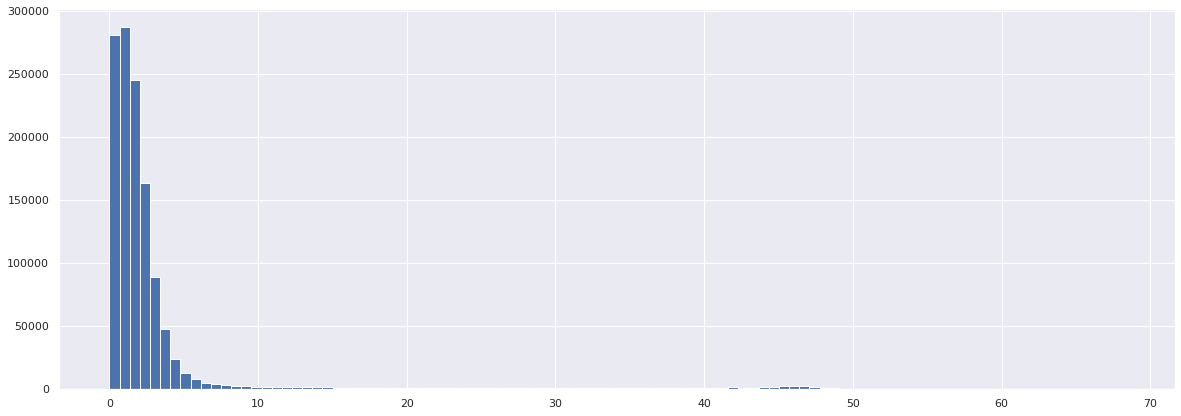

In [20]:
plt.figure(figsize=(20, 7))
y_sampled.hist(bins=100)

In [21]:
(y_sampled < 5).sum()

1143922

In [23]:
# ratio = 5
# y_sampled = pd.concat((y[y==0].sample(y.value_counts()[1]*ratio, replace=False, random_state=0),
#                        y[y==1]), axis=0)
# X_sampled = X.loc[y_sampled.index]

#X_train, X_val, y_train, y_val = train_test_split(X_sampled, y_sampled, test_size=0.25, shuffle=True, stratify=y_sampled, random_state=0)
model = catboost.CatBoostRegressor(
    iterations=1000,
    #task_type="GPU",
    #eval_metric='AUC',
    verbose=50
)
model.fit(X, y)#, eval_set=(X_val, y_val))

Learning rate set to 0.155516
0:	learn: 5.2791016	total: 725ms	remaining: 12m 4s
50:	learn: 3.4250316	total: 45.3s	remaining: 14m 3s
100:	learn: 2.6860051	total: 1m 29s	remaining: 13m 18s
150:	learn: 2.2916502	total: 2m 15s	remaining: 12m 41s
200:	learn: 2.0026829	total: 3m 2s	remaining: 12m 6s
250:	learn: 1.8119117	total: 3m 49s	remaining: 11m 26s
300:	learn: 1.6594968	total: 4m 39s	remaining: 10m 47s
350:	learn: 1.5549299	total: 5m 26s	remaining: 10m 3s
400:	learn: 1.4684575	total: 6m 14s	remaining: 9m 18s
450:	learn: 1.3921437	total: 7m 1s	remaining: 8m 33s
500:	learn: 1.3342032	total: 7m 52s	remaining: 7m 50s
550:	learn: 1.2841317	total: 8m 46s	remaining: 7m 8s
600:	learn: 1.2388086	total: 9m 36s	remaining: 6m 22s
650:	learn: 1.1977186	total: 10m 26s	remaining: 5m 35s
700:	learn: 1.1623377	total: 11m 18s	remaining: 4m 49s
750:	learn: 1.1290117	total: 12m 10s	remaining: 4m 2s
800:	learn: 1.0997812	total: 13m	remaining: 3m 13s
850:	learn: 1.0740502	total: 13m 51s	remaining: 2m 25s
90

In [24]:
with open(global_path+'model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
with open(global_path+'model.pkl', 'rb') as f:
    model = pickle.load(f)

In [25]:
model.get_feature_importance(prettified=True)[:50]#['Feature Id'].values.tolist().index('Coolness_RHEED_3500')

,Feature Id,Importances
0,Length_RHEED_max_2250,4.579988
1,Coolness_RHEED_std_500,3.368121
2,Coolness_RHEED_mean_50,3.036493
3,Length_RHEED_min_2250,3.029481
4,Coolness_RHEED_median_50,2.574063
5,Coolness_RHEED_std_50,1.862125
6,Length_RHEED_mean_2250,1.693305
7,Length_RHEED_mean_3500,1.611416
8,Source Power_std_1200,1.603122
9,Length_RHEED_mean_500,1.494307


In [ ]:
trans = lambda x: 1 / (1 + np.exp(-x + 5))
plt.plot(np.linspace(0, 10, 1000), trans(np.linspace(0, 10, 1000)))

In [ ]:
sklearn.metrics.plot_confusion_matrix(model, X_train, y_train, normalize='all')  # doctest: +SKIP
plt.show()  # doctest: +SKIP

In [ ]:
sklearn.metrics.plot_confusion_matrix(model, X_val, y_val,normalize='all')  # doctest: +SKIP
plt.show()  # doctest: +SKIP

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_val, model.predict_proba(X_val)[:,1])
roc_auc = sklearn.metrics.roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_train, model.predict_proba(X_train)[:,1])
roc_auc = sklearn.metrics.roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
plt.figure()
lw = 2
plt.plot(fpr, tpr,color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.get_feature_importance(prettified=True)[:50]

In [ ]:
pr = submission.Predictor()

In [ ]:
model.predict(X[-1000:])

In [ ]:
pr.forecast(rheed_long.iloc[-10000:])